In [1]:
#####################to be fixed!!

#!/usr/bin/env pythonP
# coding: utf-8

import netCDF4 as nc
import sys, os, argparse
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm
#Import packages for plotting
from matplotlib.colors import ListedColormap
from pylab import imshow,cm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.interpolate import griddata

year = 2009
season = "AMJ"
tmin = 29
time_steps_per_day=4
print(f"Processing year {year}, season {season}")


IC_resolution = 0.5
dt = 0.0025
DT = 0.1
# Format the variables
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"

NCores=32
K=1000
distance = 0

formatted_distance = f"{distance:.2f}"

clusters_path =  "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/2009_AMJ_ic0.5_dt0.0025_DT0.0100/clusters_K1000_border0.00_cleaned_center_spars/"
tmin=8

# Get the parent directory
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
FTLE_parent_directory = "/cluster/home/llpui9007/Programs/FTLE"
TBarrier_parent_directory = "/cluster/home/llpui9007/Programs/TBarrier-main/TBarrier/2D"


# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")
sys.path.append(FTLE_parent_directory)
# add utils folder to current working path
sys.path.append(TBarrier_parent_directory+"/subfunctions/utils")
sys.path.append(TBarrier_parent_directory+"/subfunctions/integration")
# add FTLE folder to current working path
sys.path.append(TBarrier_parent_directory+"/demos/AdvectiveBarriers/FTLE2D")


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
from parallelised_functions import split

# Import linear interpolation function for unsteady flow field with irregular grid
from Interpolant import generate_mask_interpolator , generate_velocity_interpolants, interpolant_unsteady_FTLE, interpolant_FTLE
# Import function to compute flow map/particle trajectories
from regular_regrid import regular_grid_interpolation_scalar

# Import function to compute finite time Lyapunov exponent (FTLE)
from FTLE import parallel_FTLE
from polar_rotation import polar_rotation_rx 
from calculating_borders import borders_binary


Processing year 2009, season AMJ


In [2]:
ftle_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/cleaned_FTLE_"+str(year)+"_"+season+"_dx0.100_dy0.100_dt0.100_grid_ratio0.010/"

print("Reading regrided input data")
"""
dataset = nc.Dataset(regrided_geo_file_path, mode='r')
# Access coordinates
X_domain = dataset.variables['regrided_rot_lat'][:]  
Y_domain = dataset.variables['regrided_rot_lon'][:]
dataset.close()
"""
domain_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"
X_domain = np.load(domain_path+"X_domain.npy")
Y_domain = np.load(domain_path+"Y_domain.npy")

FTLE_field = np.load(ftle_path + str(tmin) + "_FTLE.npy")
FTLE_field_plot = np.copy(FTLE_field)
mask = np.isnan(FTLE_field)
FTLE_field[np.isnan(FTLE_field)] = 0
Interpolant_FTLE = interpolant_unsteady_FTLE(X_domain, Y_domain, FTLE_field)


formatted_d=str(0)
spar=0
formatted_spar = f"{spar:.2f}"
FTLE = []


Reading regrided input data


In [3]:
#FTLE_field[550:552,150:152]
X_domain.shape

(761, 674)

In [4]:
FTLE_field

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(761, 674))

In [5]:
def plotpolar_ftle(X_domain, Y_domain, FTLE, vmin, vmax): 
  
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain),np.array(X_domain),-90) 

    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    # Choose a colormap (e.g., 'viridis')
    cmap = 'viridis'
    cax = ax.scatter(np.asarray(X_domain_rot.ravel())[0,:], np.asarray(Y_domain_rot.ravel())[0,:], c= np.asarray(FTLE.ravel())[:], cmap= cmap,transform=ccrs.PlateCarree(), s=8,vmin=vmin,vmax=vmax)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
    cbar.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)  # Adjust '14' to your desired tick size
    cbar.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])

    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    gl.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree()) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.show() 
    plt.close(fig)  # Close the figure to free up memory


In [6]:
def cut_trajectories(distance,land_mask,latitude,longitude,canadian=True, eastSval=True, canadian_greenland=True):
    from scipy.ndimage import binary_dilation
    # Define the number of cells to expand the mask
    # Create a structuring element for dilation
    structuring_element = np.ones((2 * distance + 1, 2 * distance + 1))
    # Perform binary dilation to expand the mask
    thick_land_mask = binary_dilation(land_mask, structure=structuring_element)
    from shapely.geometry import Point, Polygon

        #tangent canadian archipelago leaving greenland tail
    polygon_vertices = [
        (-25,-110),
        (-5,-83),   # Vertex 2 (latitude, longitude)
        (-45, -50),    # Vertex 4 (latitude, longitude)
        (-45, -100)
    ]
    # Create a Polygon object using shapely
    polygon = Polygon(polygon_vertices)
    # Flatten the latitude and longitude matrices to create a list of points
    points = np.column_stack((latitude.ravel(), longitude.ravel()))
    # Use a list comprehension to check if each point is inside the polygon
    inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
    # Reshape the mask back to the original shape of the latitude matrix
    polygon_land_mask = inside_mask.reshape(latitude.shape)
    
    # Count the number of points inside the polygon
    inside_points_count = np.sum(polygon_land_mask)

    if canadian_greenland==True:
        # Define the vertices of the polygon
        #tangent canadian archipelago
        polygon_vertices = [
            (-20,-110),
            (10, -50),   # Vertex 2 (latitude, longitude)
            (-35, -50),    # Vertex 4 (latitude, longitude)
            (-40, -90)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    if eastSval==True:
        #east of svalbard
        polygon_vertices = [
            (26,-70),
            (15, -98),   # Vertex 2 (latitude, longitude)
            (-20, -52),    # Vertex 4 (latitude, longitude)
            (-4, -54)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    
    
    # Output the number of points inside the polygon
    print("Number of points inside the polygons:")
    print(str(inside_points_count))
    expanded_land_mask = thick_land_mask + polygon_land_mask
    return expanded_land_mask
    

In [7]:
exp_mask = cut_trajectories(0,mask,Y_domain,X_domain,canadian=True, eastSval=True, canadian_greenland=True)

Number of points inside the polygons:
281832


Processing 9 clusters


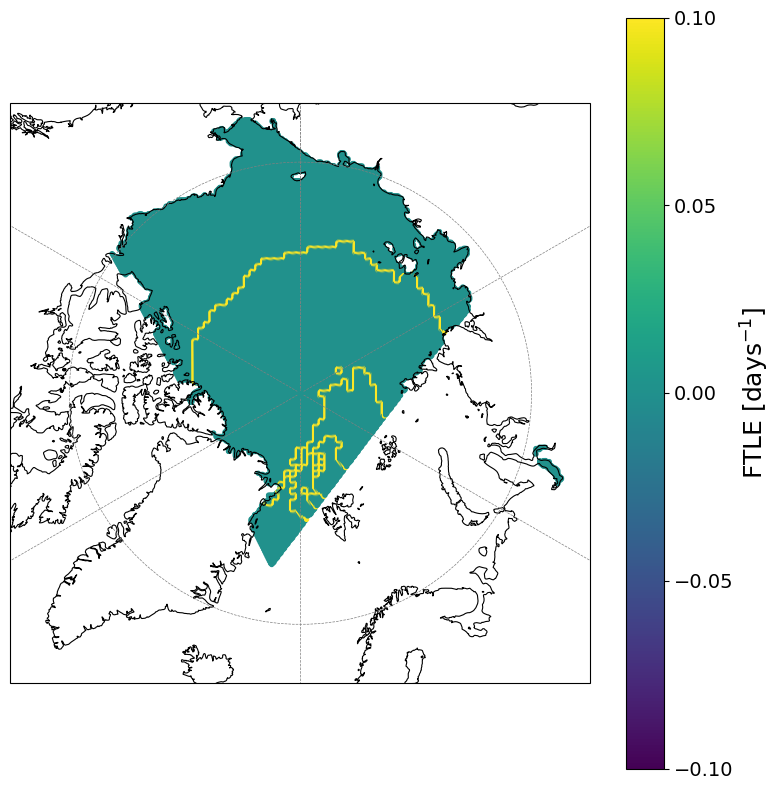

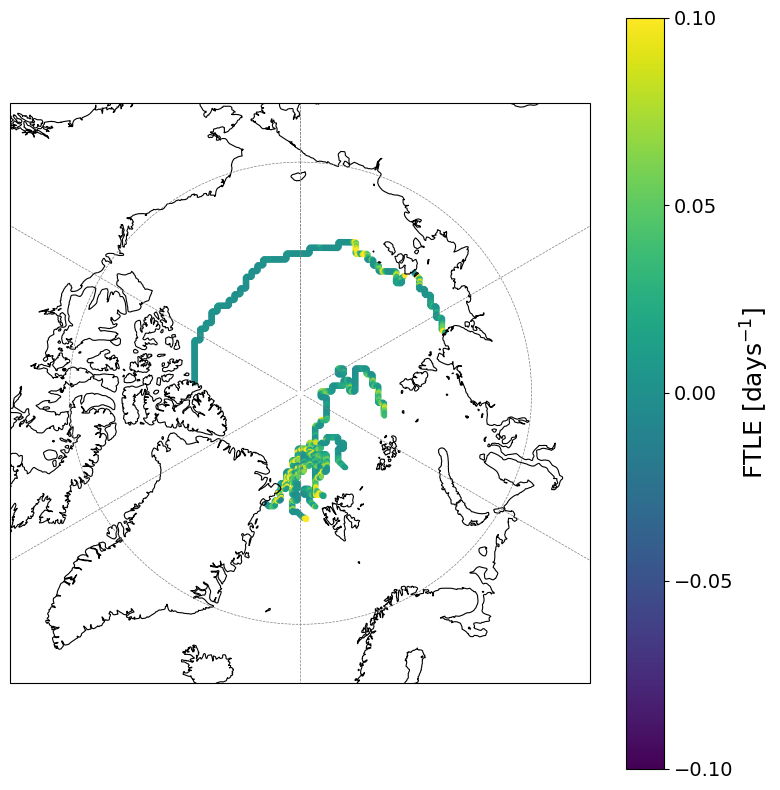

In [11]:
n_clusters=9
print("Processing "+str(n_clusters)+" clusters")
Fmap_path = clusters_path+'tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy'
labels_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels.npy'
labels_disp_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels_disp.npy'
labels_reweighted_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels_reweighted.npy'

Fmap = np.load(Fmap_path)
labels= np.load(labels_path)
labels_disp = np.load(labels_disp_path)
labels_reweighted = np.load(labels_reweighted_path)

IC = Fmap[0,:,:]  #Take the position of the trajectory IC
# Load the labels of the clusters
grid_labels = griddata((IC[0, :], IC[1, :]), labels_disp, (X_domain,Y_domain), method='nearest')
borders_avg = borders_binary(grid_labels)
#plotpolar_ftle(X_domain, X_domain, borders_avg , -0.1, 0.1)
borders_avg = np.where(exp_mask,np.nan, borders_avg)
plotpolar_ftle(X_domain, Y_domain, borders_avg , -0.1, 0.1)

borders_idx = np.where(borders_avg==1)
borders_lon_rot = X_domain[borders_idx]
borders_lat_rot = Y_domain[borders_idx]
FTLEn = Interpolant_FTLE(borders_lat_rot, borders_lon_rot, grid=False)
plotpolar_ftle(borders_lon_rot, borders_lat_rot, FTLEn , -0.1, 0.1)

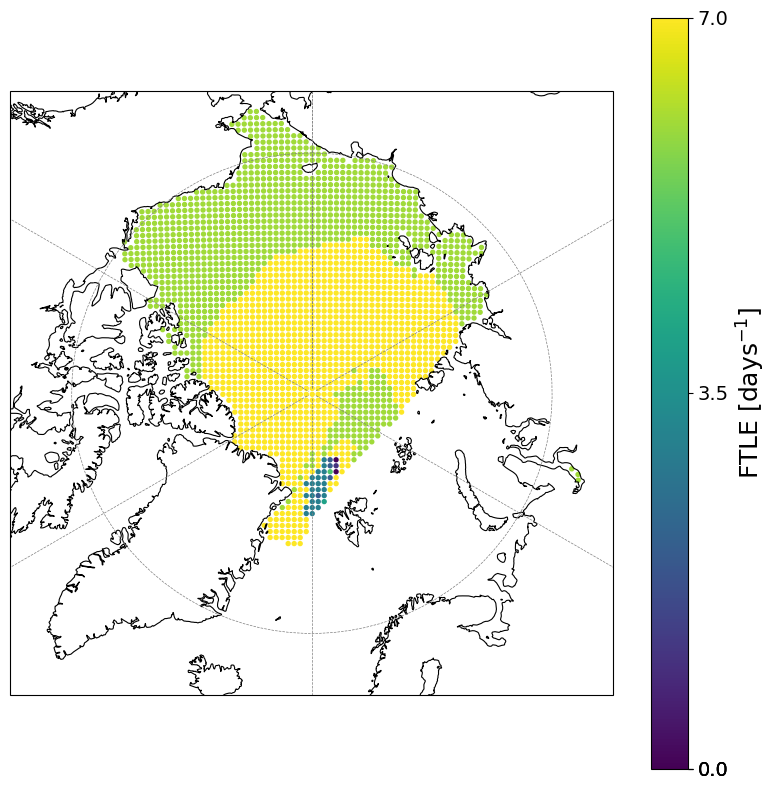

In [13]:
plotpolar_ftle(IC[0, :], IC[1, :], labels_disp,0,7)

Processing 2 clusters
Processing 5 clusters
Processing 8 clusters
Processing 11 clusters
Processing 14 clusters
Processing 17 clusters
Data for 17 clusters not found. Skipping...
Processing 20 clusters
Data for 20 clusters not found. Skipping...
Processing 23 clusters
Data for 23 clusters not found. Skipping...
Processing 26 clusters
Data for 26 clusters not found. Skipping...
Processing 29 clusters
Data for 29 clusters not found. Skipping...


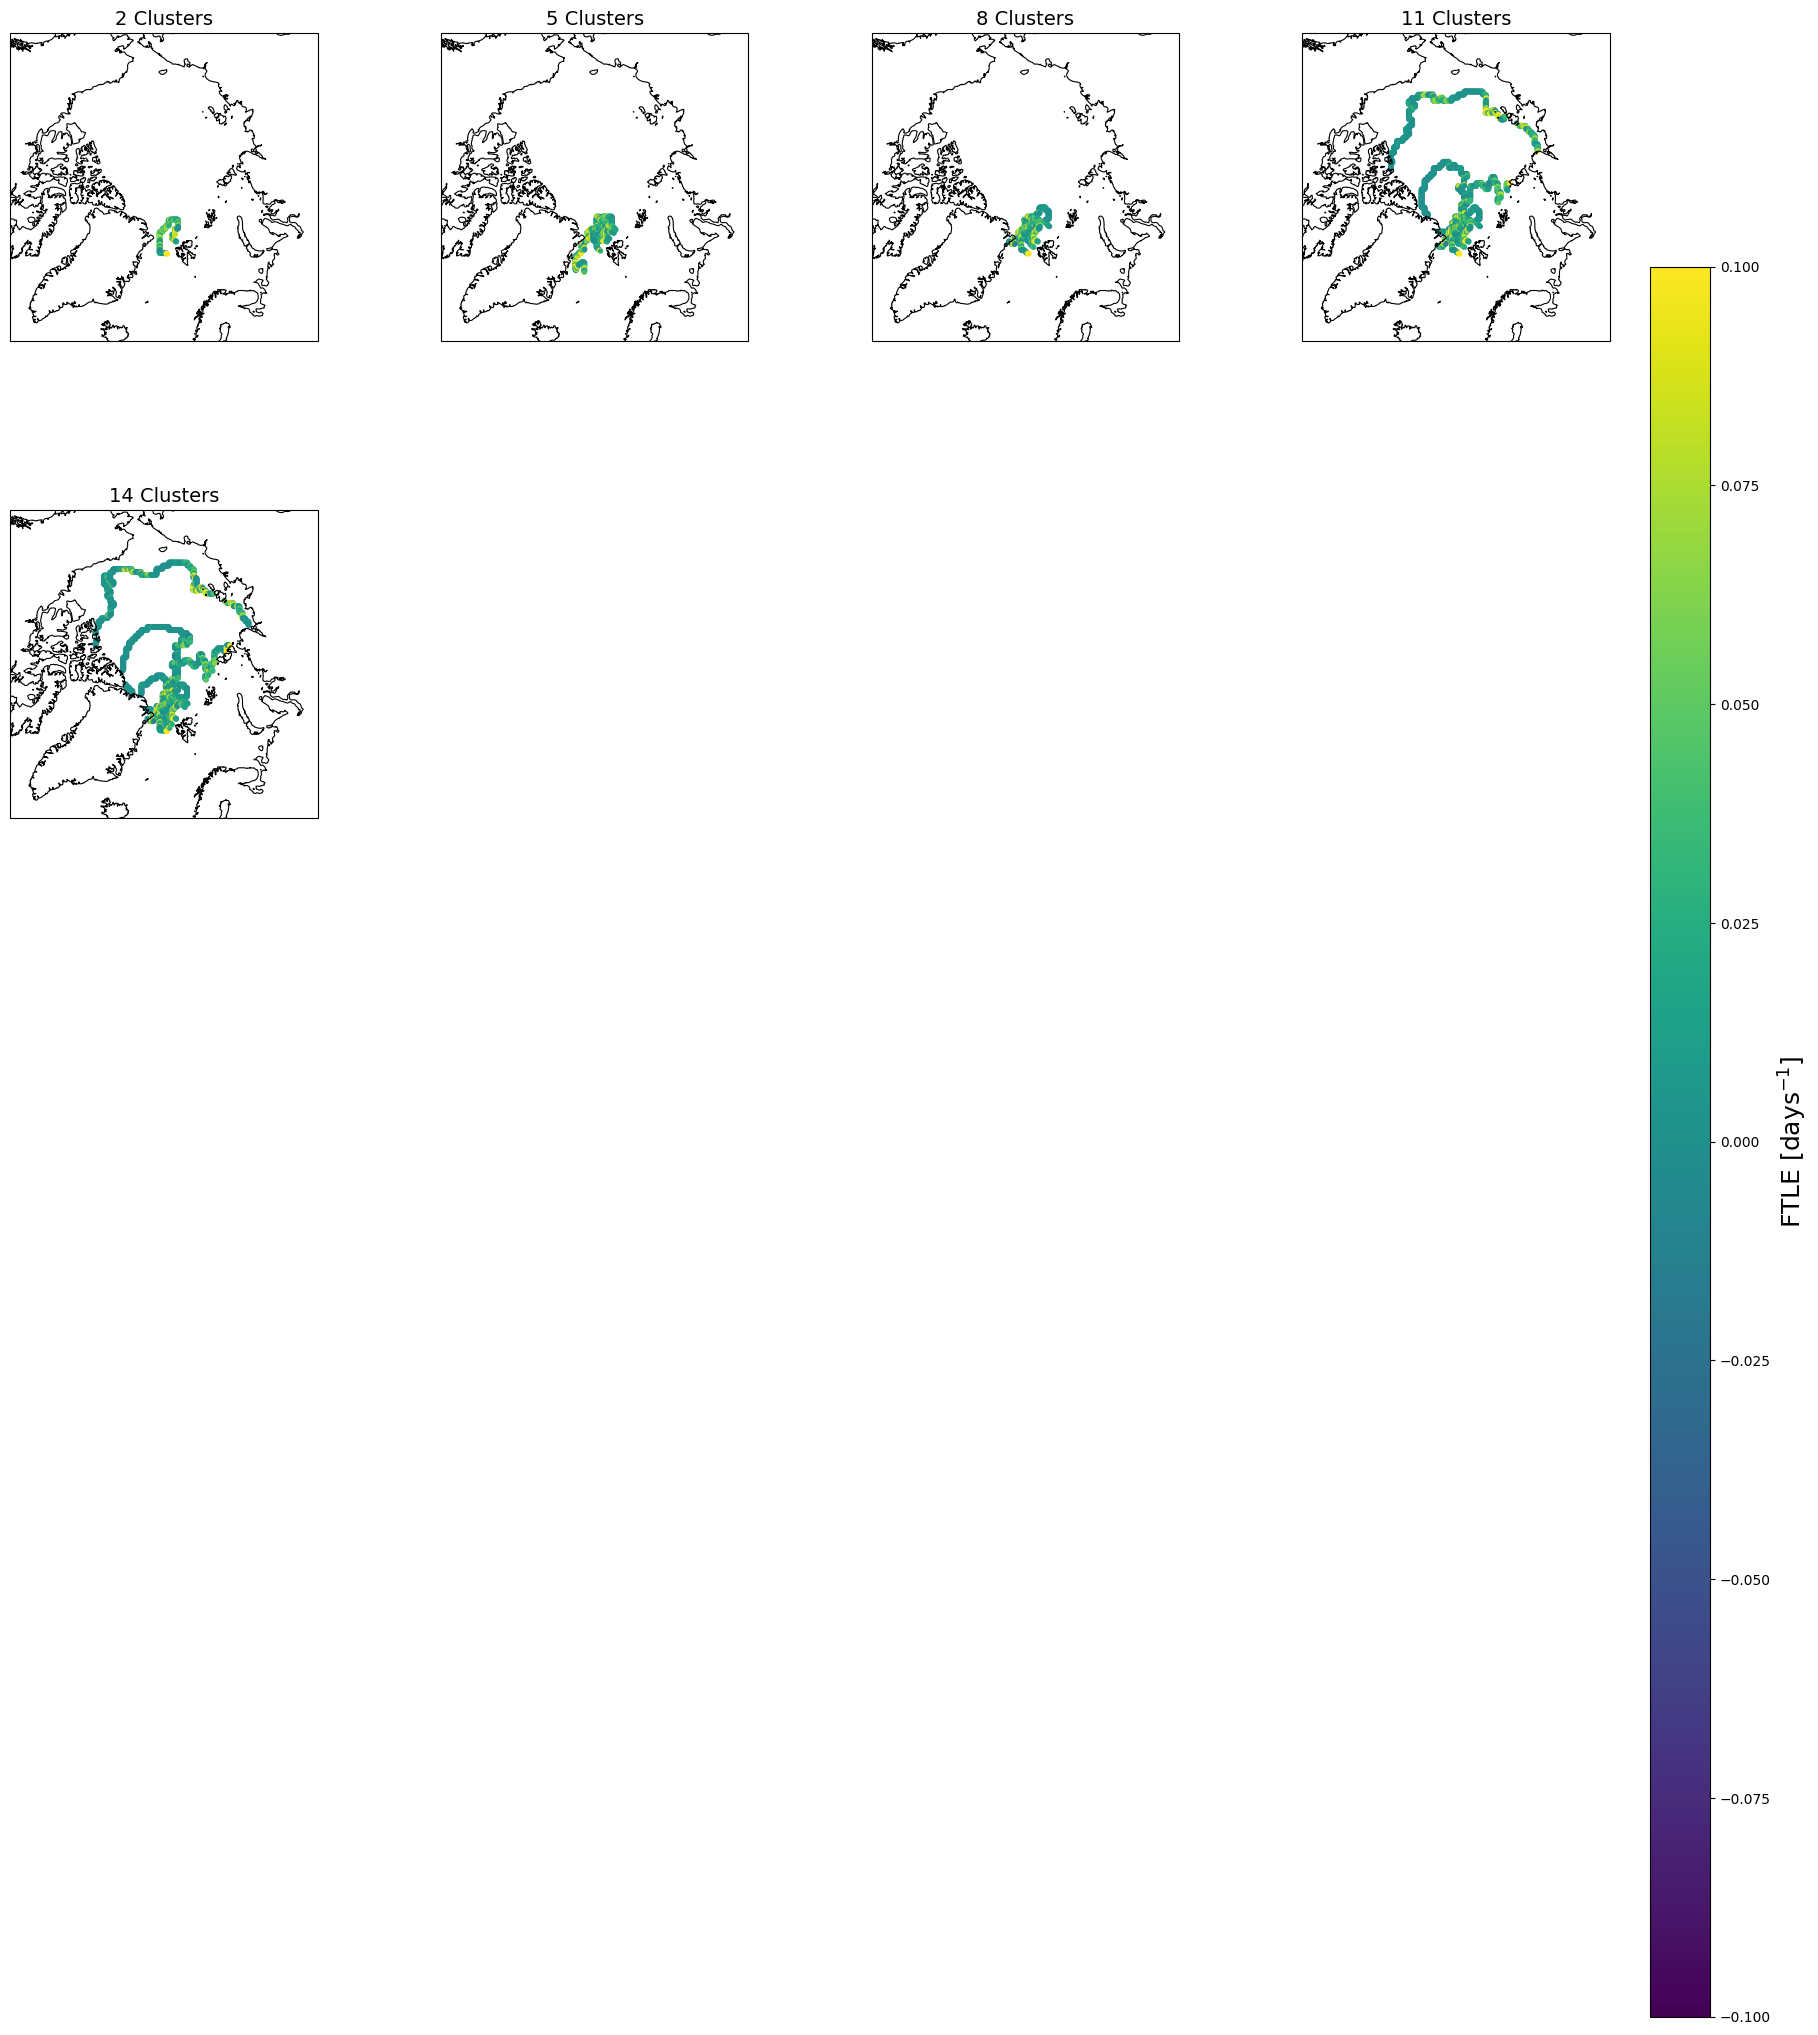

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
# Assuming the required functions like `borders_binary`, `Interpolant_FTLE`, and `polar_rotation_rx` are already defined.
# Define the range of clusters
n_clusters_range = range(2, 30, 3)
# Create a figure with subplots
fig = plt.figure(figsize=(20, 25))
n_plots = 0  # Counter for valid plots
# Loop through the range of clusters
for n_clusters in n_clusters_range:
    print(f"Processing {n_clusters} clusters")
    
    # File paths
    Fmap_path = clusters_path + f'tmin{int(tmin)}_spar{formatted_spar}_labels_Fmap_cut.npy'
    labels_path = clusters_path + f'{n_clusters}_tmin{int(tmin)}_spar{formatted_spar}_labels.npy'
    labels_disp_path = clusters_path + f'{n_clusters}_tmin{int(tmin)}_spar{formatted_spar}_labels_disp.npy'
    labels_reweighted_path = clusters_path + f'{n_clusters}_tmin{int(tmin)}_spar{formatted_spar}_labels_reweighted.npy'
    
    # Load data
    try:
        Fmap = np.load(Fmap_path)
        labels = np.load(labels_path)
        labels_disp = np.load(labels_disp_path)
        labels_reweighted = np.load(labels_reweighted_path)
    except FileNotFoundError:
        print(f"Data for {n_clusters} clusters not found. Skipping...")
        continue
    # Extract initial conditions (IC)
    IC = Fmap[0, :, :]  # Take the position of the trajectory IC
    # Interpolate the labels onto the grid
    grid_labels = griddata((IC[0, :], IC[1, :]), labels_disp, (X_domain, Y_domain), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels_disp, (X_domain, Y_domain), method='linear'))
    
    # Compute borders
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(exp_mask, np.nan, borders_avg)
    borders_idx = np.where(borders_avg == 1)
    borders_lon_rot = X_domain[borders_idx]
    borders_lat_rot = Y_domain[borders_idx]
    
    # Check if there is valid data to plot
    if borders_lon_rot.size == 0 or borders_lat_rot.size == 0:
        print(f"No data for {n_clusters} clusters. Skipping...")
        continue
    # Compute FTLE
    FTLEn = Interpolant_FTLE(borders_lat_rot, borders_lon_rot, grid=False)
    # Add a subplot for this cluster
    ax = fig.add_subplot(5, 4, n_plots + 1, projection=ccrs.NorthPolarStereo())
    n_plots += 1
    # Rotate the domain
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(borders_lat_rot), np.array(borders_lon_rot), -90)
    # Plot the data
    cmap = 'viridis'
    cax = ax.scatter(
        np.asarray(X_domain_rot.ravel())[0, :],
        np.asarray(Y_domain_rot.ravel())[0, :],
        c=np.asarray(FTLEn.ravel())[:],
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        s=8,
        vmin=-0.1,
        vmax=0.1
    )
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax.set_title(f"{n_clusters} Clusters", fontsize=14)
# Remove empty subplots
if n_plots == 0:
    print("No valid data found for any clusters.")
    plt.close(fig)
else:
    # Adjust layout to leave space for the colorbar
    fig.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.4, hspace=0.4)
    
    # Add the colorbar to the right of the figure
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(cax, cax=cbar_ax)
    cbar.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    # Save and show the combined plot
    plt.savefig("combined_clusters_plot_filtered.png", dpi=300)
    plt.show()

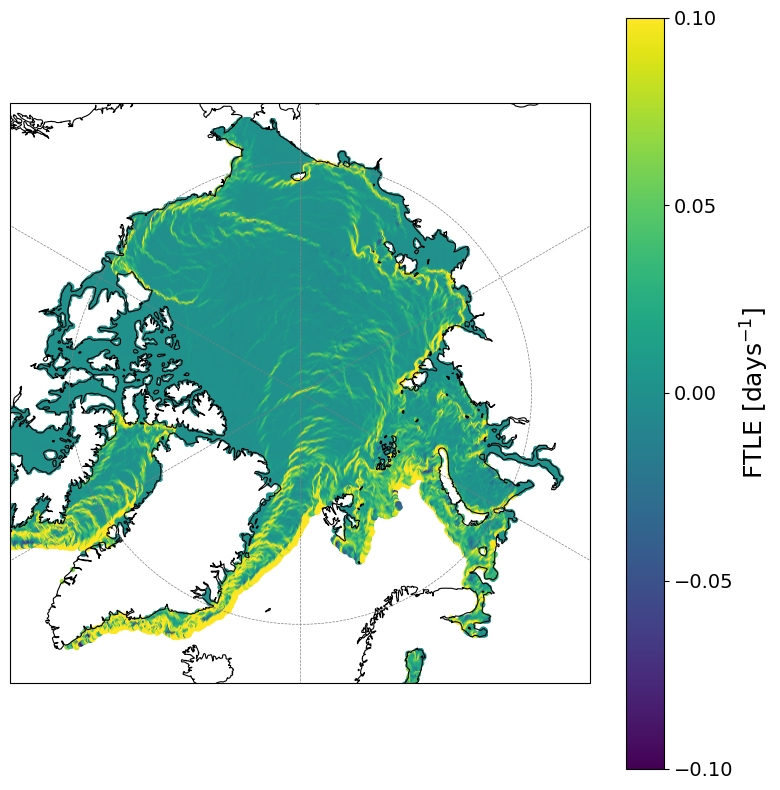

In [12]:
plotpolar_ftle(X_domain, Y_domain, FTLE_field_plot, -0.1, 0.1)

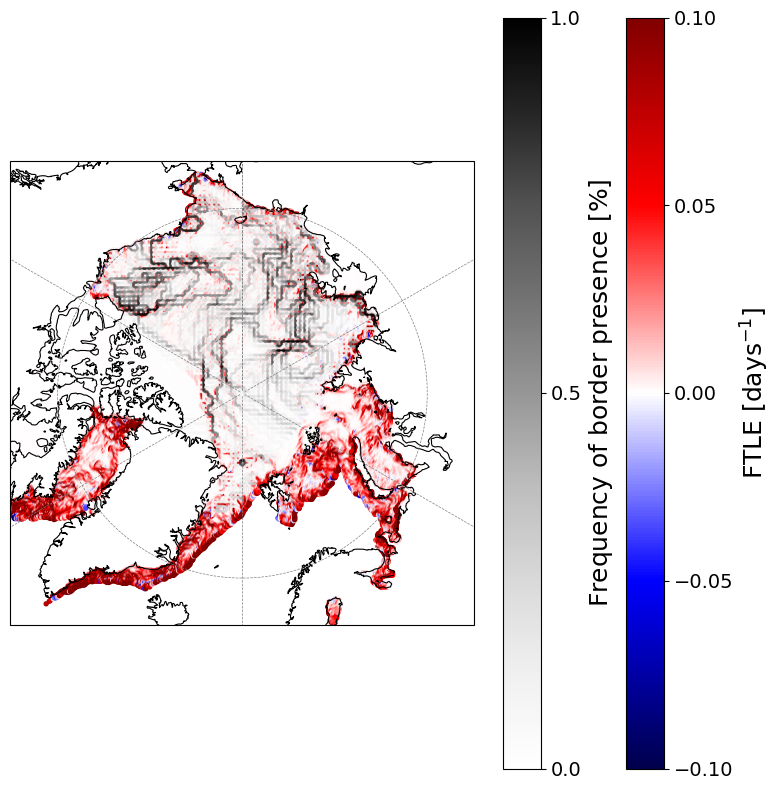

In [42]:
plotpolar_ftle_avg_2(X_domain, Y_domain, FTLE_field_plot, borders_avg_reweighted, -0.1, 0.1, 0)

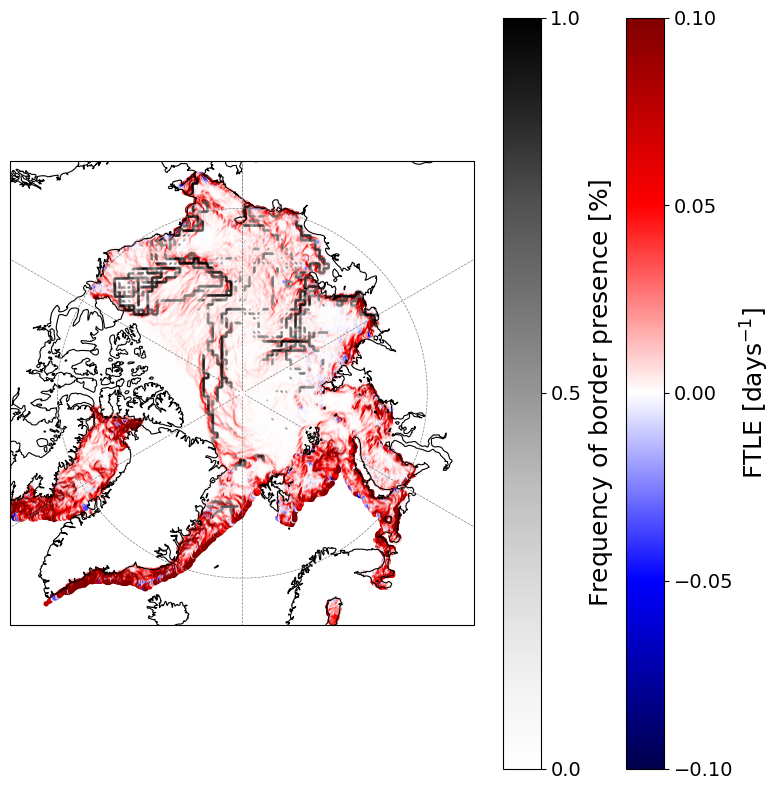

In [44]:
plotpolar_ftle_avg_2(X_domain, Y_domain, FTLE_field_plot, borders_avg_50, -0.1, 0.1)

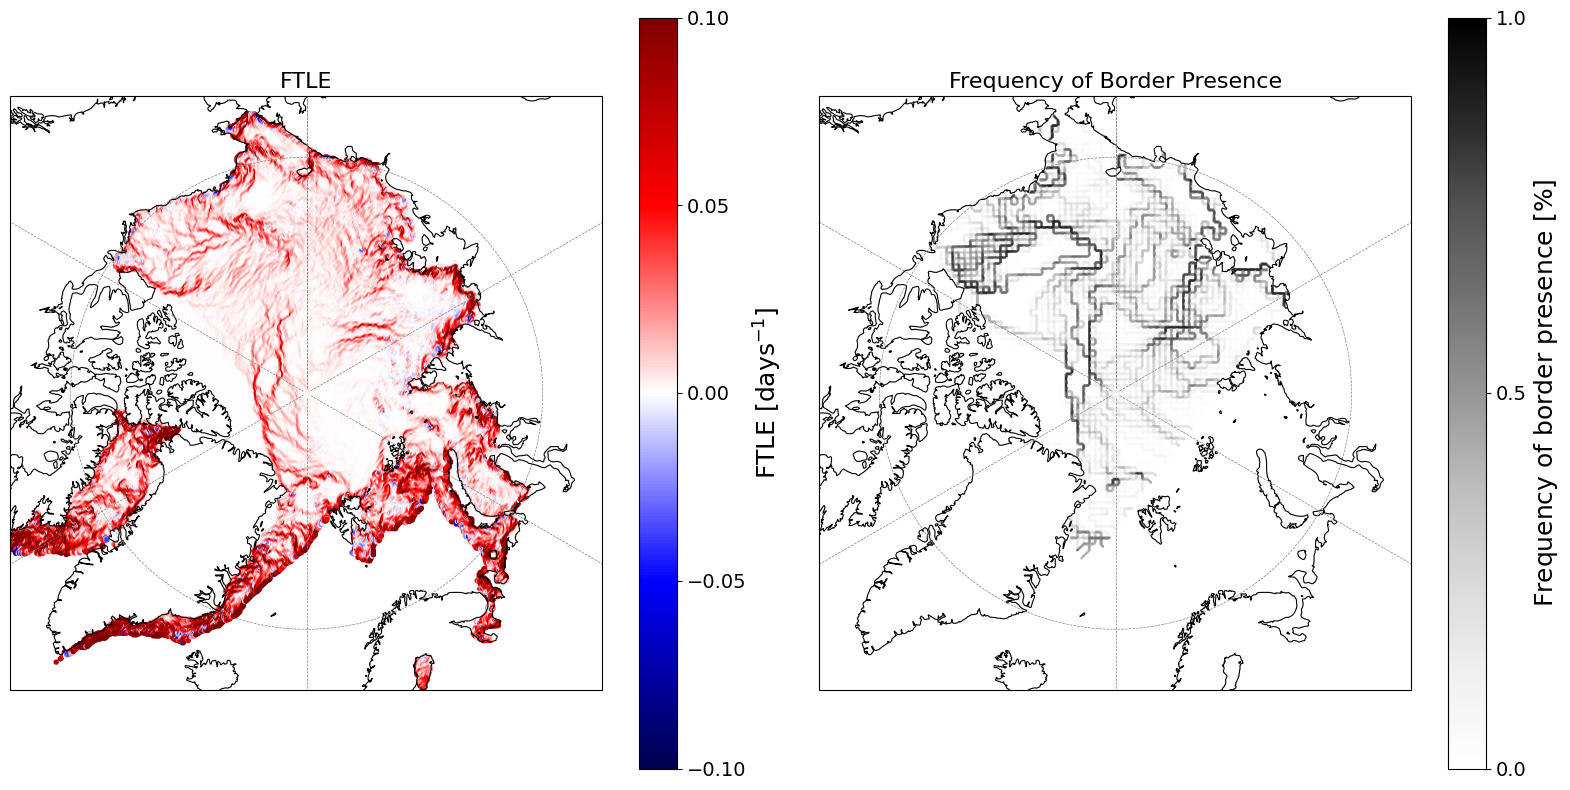

In [32]:
plotpolar_ftle_avg(X_domain, Y_domain, FTLE_field_plot, borders_avg, -0.1, 0.1)


In [43]:
def plotpolar_ftle_avg_2(X_domain, Y_domain, FTLE, borders_avg, vmin, vmax): 
  
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain),np.array(X_domain),-90) 

    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    # Choose a colormap (e.g., 'viridis')
    cmap_ftle = 'seismic'
    cmap_avg = 'Greys'
    cax = ax.scatter(np.asarray(X_domain_rot.ravel())[0,:], np.asarray(Y_domain_rot.ravel())[0,:], c= np.asarray(FTLE.ravel())[:], cmap= cmap_ftle,transform=ccrs.PlateCarree(), s=8,vmin=vmin,vmax=vmax)
    cax_avg = ax.scatter(np.asarray(X_domain_rot.ravel())[0,:], np.asarray(Y_domain_rot.ravel())[0,:], c= np.asarray(borders_avg.ravel())[:], cmap= cmap_avg,transform=ccrs.PlateCarree(), s=0.1,vmin=0,vmax=1)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
    cbar.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)  # Adjust '14' to your desired tick size
    cbar.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
    cbar2 = fig.colorbar(cax_avg, ticks = np.linspace(0, .4, 9))
    cbar2.set_label('Frequency of border presence [$\%$]', fontsize=18)
    cbar2.ax.tick_params(labelsize=14)  # Adjust '14' to your desired tick size
    cbar2.set_ticks([0, 0.5, 1])

    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    gl.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree()) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.show() 
    plt.close(fig)  # Close the figure to free up memory


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
def plotpolar_ftle_avg(X_domain, Y_domain, FTLE, borders_avg, vmin, vmax): 
    # Rotate the domains
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain), np.array(X_domain), -90) 
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(
        1, 2,  # 1 row, 2 columns
        figsize=(16, 8),  # Adjust figure size
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection
    )
    # Colormaps
    cmap_ftle = 'seismic'
    cmap_avg = 'Greys'
    # Plot FTLE on the first subplot
    ax1 = axes[0]
    cax1 = ax1.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(FTLE.ravel())[:], 
        cmap=cmap_ftle, 
        transform=ccrs.PlateCarree(), 
        s=8, 
        vmin=vmin, 
        vmax=vmax
    )
    cbar1 = fig.colorbar(cax1, ax=ax1, orientation='vertical', pad=0.05)
    cbar1.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    cbar1.ax.tick_params(labelsize=14)
    cbar1.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax1.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl1.ylocator = plt.MultipleLocator(35)
    ax1.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax1.set_title("FTLE", fontsize=16)
    # Plot borders_avg on the second subplot
    ax2 = axes[1]
    cax2 = ax2.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(borders_avg.ravel())[:], 
        cmap=cmap_avg, 
        transform=ccrs.PlateCarree(), 
        s=0.1, 
        vmin=0, 
        vmax=1
    )
    cbar2 = fig.colorbar(cax2, ax=ax2, orientation='vertical', pad=0.05)
    cbar2.set_label('Frequency of border presence [$\%$]', fontsize=18)
    cbar2.ax.tick_params(labelsize=14)
    cbar2.set_ticks([0, 0.5, 1])
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl2 = ax2.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl2.ylocator = plt.MultipleLocator(35)
    ax2.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax2.set_title("Frequency of Border Presence", fontsize=16)
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

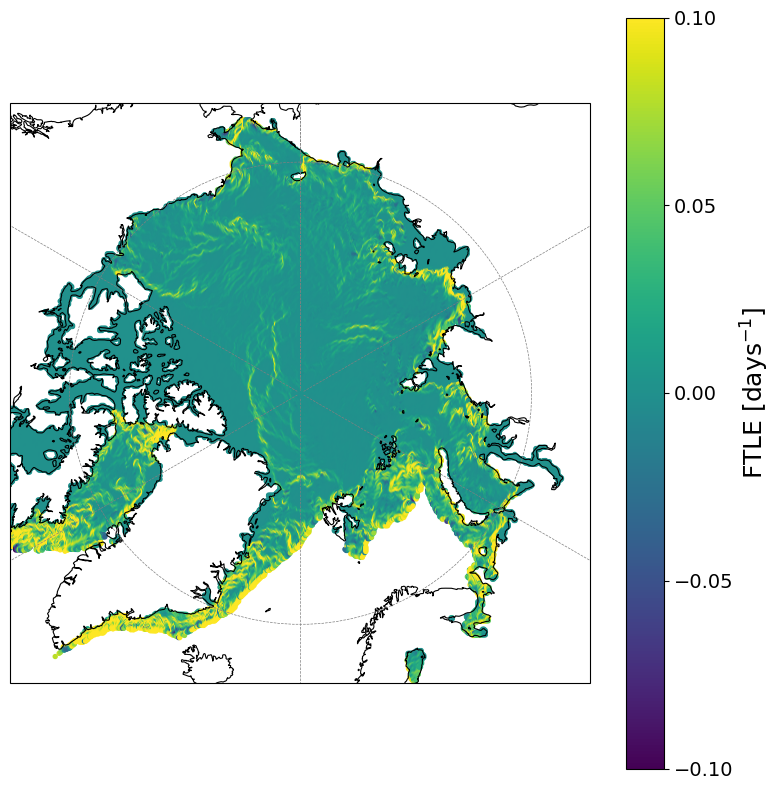

In [37]:
plotpolar_ftle(X_domain, Y_domain, FTLE_field, -0.1, 0.1)

Processing 2 clusters
Processing 3 clusters
Processing 4 clusters
Processing 5 clusters
Processing 6 clusters
Processing 7 clusters
Processing 8 clusters
Processing 9 clusters
Processing 10 clusters
Processing 11 clusters
Processing 12 clusters
Processing 13 clusters
Processing 14 clusters
Processing 15 clusters
Processing 16 clusters
Processing 17 clusters
Processing 18 clusters
Processing 19 clusters
Processing 20 clusters
Processing 21 clusters
Processing 22 clusters
Processing 23 clusters
Processing 24 clusters
Processing 25 clusters
Processing 26 clusters
Processing 27 clusters
Processing 28 clusters
Processing 29 clusters
Processing 30 clusters
Processing 31 clusters
Processing 32 clusters
Processing 33 clusters
Processing 34 clusters
Processing 35 clusters
Processing 36 clusters
Processing 37 clusters
Processing 38 clusters
Processing 39 clusters
Processing 40 clusters
Processing 41 clusters
Processing 42 clusters
Processing 43 clusters
Processing 44 clusters
Processing 45 clust

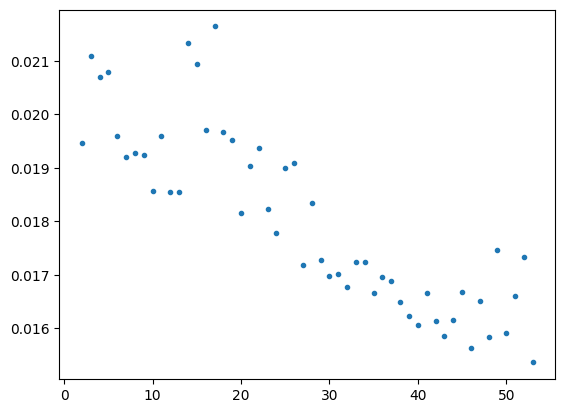

In [118]:
for n_clusters in range (2, 54): #:100):
    print("Processing "+str(n_clusters)+" clusters")
    Fmap_path = clusters_path+'tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy'
    labels_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels.npy'
    labels_disp_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels_disp.npy'
    labels_reweighted_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels_reweighted.npy'

    Fmap = np.load(Fmap_path)
    labels= np.load(labels_path)
    labels_disp = np.load(labels_disp_path)
    labels_reweighted = np.load(labels_reweighted_path)

    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    grid_labels = griddata((IC[0, :], IC[1, :]), labels_disp, (X_domain,Y_domain), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels_disp, (X_domain,Y_domain), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(mask,np.nan, borders_avg)
    borders_idx = np.where(borders_avg==1)
    borders_lon_rot = X_domain[borders_idx]
    borders_lat_rot = Y_domain[borders_idx]
    FTLE.append(Interpolant_FTLE(borders_lat_rot, borders_lon_rot, grid=False))


mean_FTLE = []
idx = []
for i in range(0,len(FTLE)):
    mean_FTLE.append(np.mean(FTLE[i]))
    idx.append(2+i)

plt.plot(idx,mean_FTLE, ".")
plt.xlabel("Number of clusters",fontsize=16)
plt.ylabel("Average FTLE in borders",fontsize=16)
plt.title("FTLE in cluster borders vs number of clusters",fontsize=16)


In [64]:
n_clusters=3
print("Processing "+str(n_clusters)+" clusters")
Fmap_path = clusters_path+'tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy'
labels_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels.npy'
labels_disp_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels_disp.npy'
labels_reweighted_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels_reweighted.npy'

Fmap = np.load(Fmap_path)
labels= np.load(labels_path)
labels_disp = np.load(labels_disp_path)
labels_reweighted = np.load(labels_reweighted_path)

IC = Fmap[0,:,:]  #Take the position of the trajectory IC
# Load the labels of the clusters
grid_labels = griddata((IC[0, :], IC[1, :]), labels_disp, (X_domain,Y_domain), method='nearest')
fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels_disp, (X_domain,Y_domain), method='linear'))
borders_avg = borders_binary(grid_labels)
borders_avg = np.where(fmap_mask,np.nan, borders_avg)
borders_idx = np.where(borders_avg==1)
borders_lon_rot = X_domain[borders_idx]
borders_lat_rot = Y_domain[borders_idx]


Processing 3 clusters


In [ ]:

np.save(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".npy", FTLE)
print("ftle.npy saved")
plt.savefig(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".png")

In [ ]:

np.save(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".npy", FTLE)
print("ftle.npy saved")
plt.savefig(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".png")